In [17]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from util.methods import assign_variances
seed = 712
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 50, 500).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 51)
y_integers = y_dense[np.linspace(0, 499, 50, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/10).astype(int)
group_names = [f"第{i+1}组" for i in range(5)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5种不同颜色
for group in range(5):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=600,
    width=900,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [18]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999942967-1.4284354143439277e-15j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


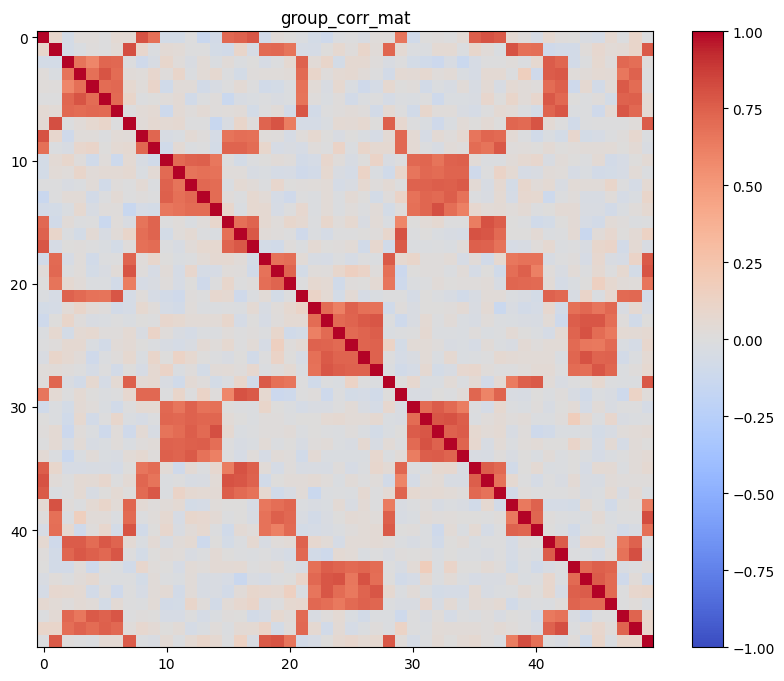

In [19]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 50
within_group_mean = 0.8
between_group_mean = 0.0
noise_std = 0.1 

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [20]:
group_labels+1

array([2, 3, 4, 4, 4, 4, 4, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
       5, 5, 5, 5, 5, 5, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5,
       5, 5, 5, 4, 4, 3])

验证结果:
方差范围: 30.24-132.03 (目标: 25-144)
最小特征值: 0.000000 (应>0)


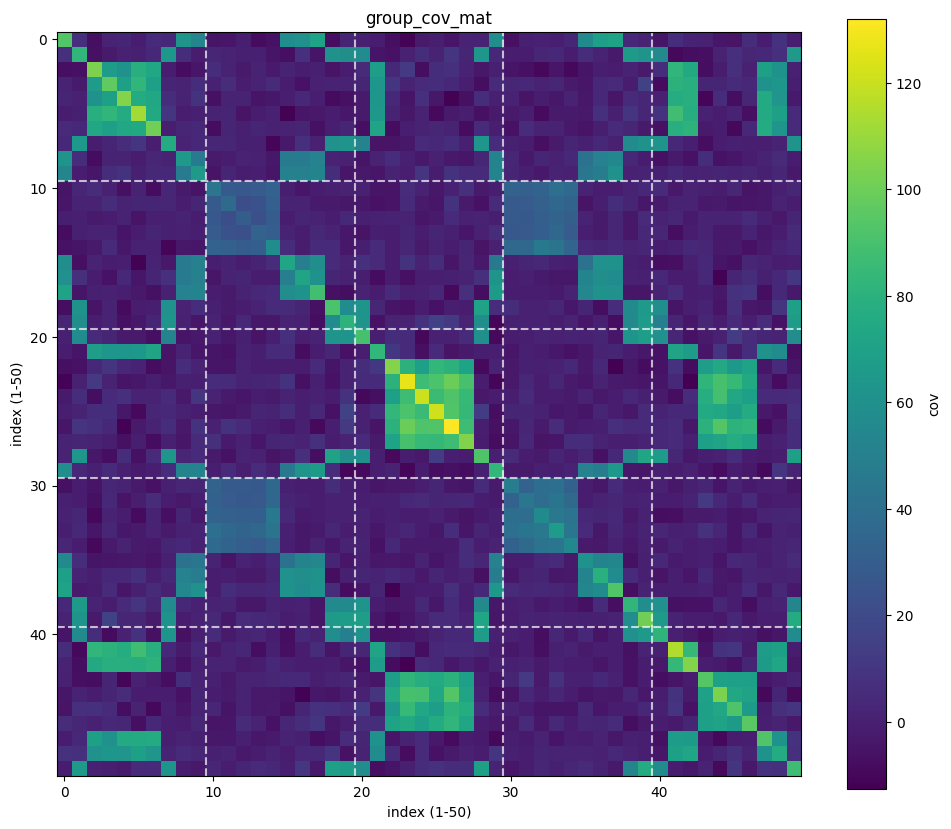

In [21]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [22]:
y_integers

array([70.52703273, 71.70101761, 73.11852288, 74.29964654, 74.96801302,
       74.994665  , 74.17675843, 72.7617962 , 70.945903  , 68.82343387,
       66.87260265, 65.2689593 , 64.78550408, 65.34830242, 66.67194613,
       68.43730219, 69.90114094, 70.97446711, 71.5565354 , 72.13189639,
       72.99377913, 74.39596317, 76.07631608, 77.63680396, 78.56506464,
       78.50819417, 77.55129525, 75.63209341, 72.80132442, 70.09933881,
       67.89571871, 66.54289196, 66.13421433, 66.90331494, 68.11195124,
       69.36108272, 70.33756443, 70.91697967, 71.44161928, 72.17254431,
       73.02768303, 74.17641939, 75.10717777, 75.84339692, 75.91926191,
       75.72430144, 75.17699478, 74.34038125, 73.24529782, 72.16823919])

In [23]:
variances

array([ 93.122617  ,  82.8713581 , 103.29076433,  96.85426621,
       105.35752395, 111.98016739, 101.26509256,  76.4309486 ,
        65.11573164,  65.27673625,  44.2926181 ,  37.30073172,
        30.24441131,  33.21682437,  57.66234154,  72.78649542,
        72.09211247,  88.10666132,  91.3353938 ,  80.93982613,
        89.87688457,  83.22081378, 105.10396118, 126.58365238,
       120.86021917, 121.73813602, 132.02945044, 104.65155876,
        92.25479169,  83.4259667 ,  48.91742774,  44.46893173,
        56.55435567,  66.98127952,  55.18119311,  61.09300255,
        78.99333205,  92.56955406,  82.59218184, 100.53759231,
        81.53384726, 114.61752346, 105.1418386 ,  93.73461292,
       103.71538548,  92.15477708,  95.1507268 ,  92.80342975,
        76.66434596,  87.25865878])

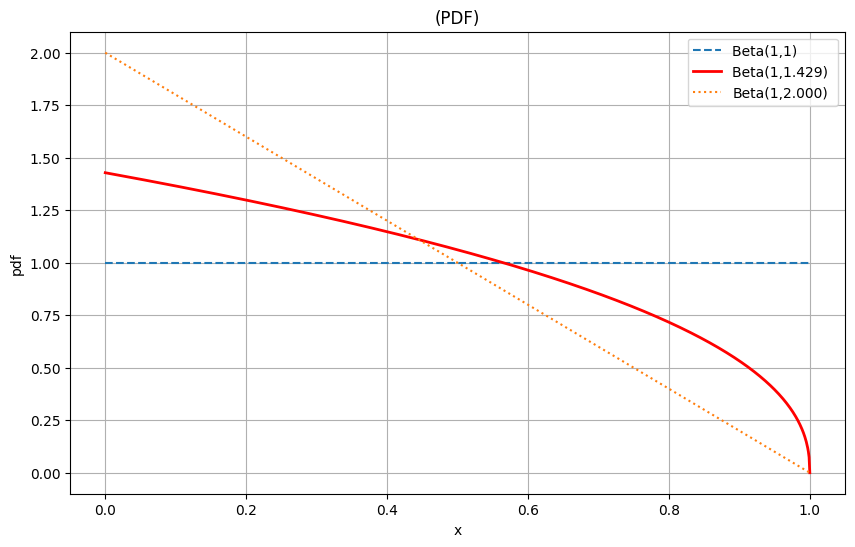

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# 设置参数
a = 1
b = 1/0.7  # ≈1.428
c = 1/0.5  # ≈1.428

# 生成x轴数据
x = np.linspace(0, 1, 1000)

# 计算不同参数下的Beta分布PDF
y1 = beta.pdf(x, a=1, b=1)          # 均匀分布
y2 = beta.pdf(x, a=1, b=b)      # 函数中使用的参数
y3 = beta.pdf(x, a=1, b=c)        # 对比案例：b<1

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Beta(1,1) ', linestyle='--')
plt.plot(x, y2, label=f'Beta(1,{b:.3f}) ', linewidth=2, color='red')
plt.plot(x, y3, label=f'Beta(1,{c:.3f})', linestyle=':')

plt.title('(PDF)')
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend()
plt.grid(True)
plt.show()